In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import pandas as pd
torch.cuda.set_device(1)
import albumentations as A

In [2]:
df = pd.read_csv('dfNew5.csv')

In [3]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='convmixer_768_32_semisupervised'),MixUp(),
    # ReduceLROnPlateau(patience=2)
]

In [4]:
db = DataBlock(blocks = (ImageBlock, RegressionBlock),
             splitter=ColSplitter('Split'),
             get_x = ColReader(0),
             get_y=ColReader(1),
             item_tfms = [Resize(640)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])

In [5]:
dls = db.dataloaders(df,bs=16)

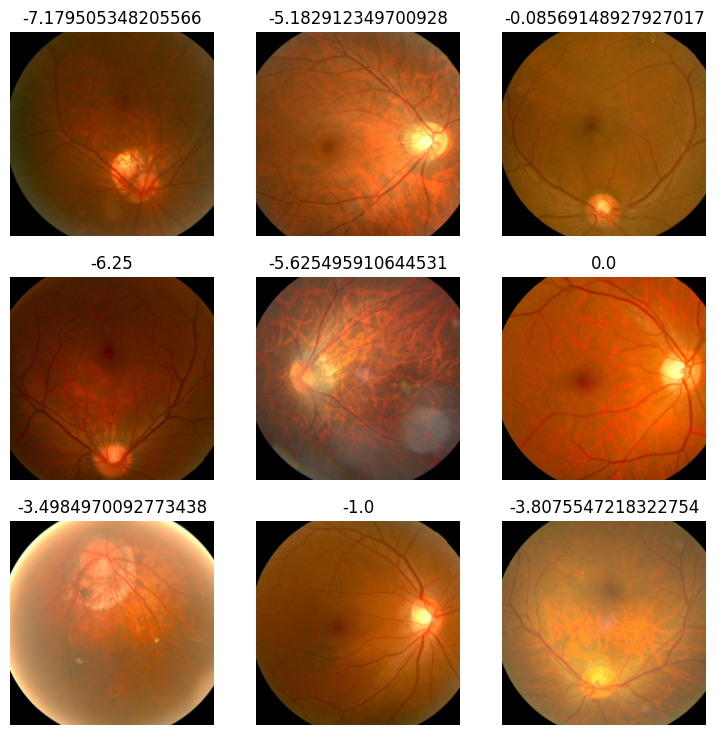

In [6]:
dls.show_batch()

In [7]:
modelo=timm.models.convmixer_768_32(num_classes=1,pretrained=True)

In [8]:
learn = Learner(dls,modelo,
            loss_func=MSELossFlat(), metrics=[mae,rmse,mse],
            cbs=callbacks,opt_func=ranger).to_fp16()

In [9]:
learn.load('convmixer_768_32')

/home/joheras/.conda/envs/python38/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,1.855402,1.154919,0.752990,1.074671,1.154919,04:22
1,1.677633,3.646277,1.590681,1.909523,3.646277,04:24
2,1.613043,nan,nan,nan,nan,04:24


Better model found at epoch 0 with valid_loss value: 1.1549185514450073.


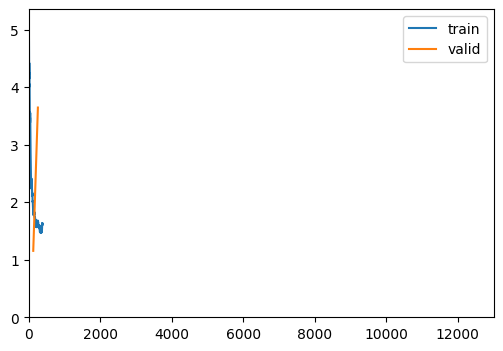

KeyboardInterrupt: 

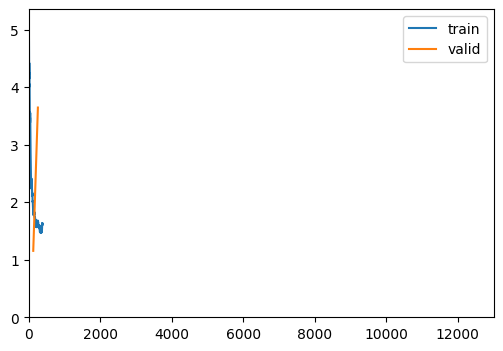

In [10]:
learn.freeze()
learn.fit_flat_cos(100,3e-3)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
preds,y=learn.get_preds()

In [ ]:
print(mean_absolute_error(preds,y))

In [ ]:
print(mean_squared_error(preds,y))

In [ ]:
# learn1 = vision_learner(dls,convnext_base,pretrained=True)
# learn1.load('convnext_base_semisupervised')
# learn1.export('models/convnext_base_semisupervised.pkl')

In [ ]:
# learn1 = vision_learner(dls,convnext_base,pretrained=True)
# learn1.load('convnext_base_semisupervised_v4')
# learn1.export('models/convnext_base_semisupervised_v4.pkl')

In [11]:
learn1 = Learner(dls,modelo)
learn1.load('convmixer_768_32_semisupervised')
learn1.export('convmixer_768_32_semisupervised.pkl')